### Import packages

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image, ImageStat

from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import numpy as np
import cv2
from collections import Counter
from skimage.color import rgb2lab, deltaE_cie76
import os
import math
import pickle

import requests as rq
import time
from selenium.webdriver.common.keys import Keys
from selenium.common.exceptions import NoSuchElementException
from selenium import webdriver
from selenium.webdriver.chrome.options import Options
import webcolors

### Import data

In [4]:
path = 'petfinder-pawpularity-score'
train_df = pd.read_csv(str(path) + '/train.csv', sep= ';')
train_df['path'] = train_df['Id'].map(lambda x:str(str(path) + '/train/' + str(x))+'.jpg')

cat_or_dog = pd.read_csv('cat_class.csv')
df = pd.merge(train_df, cat_or_dog, how="left", on="Id")

df_cat = df[df['is_cat'] == 1].reset_index()
df_cat.head()

,index,Id,Subject Focus,Eyes,Face,Near,Action,Accessory,Group,Collage,Human,Occlusion,Info,Blur,Pawpularity,path,is_cat
0,1,0009c66b9439883ba2750fb825e1d7db,0,1,1,0,0,0,0,0,0,0,0,0,42,petfinder-pawpularity-score/train/0009c66b9439...,1
1,8,0042bc5bada6d1cf8951f8f9f0d399fa,0,1,1,1,0,0,0,0,0,0,0,0,53,petfinder-pawpularity-score/train/0042bc5bada6...,1
2,9,0049cb81313c94fa007286e9039af910,0,1,1,1,0,0,0,0,0,0,0,0,21,petfinder-pawpularity-score/train/0049cb81313c...,1
3,10,005017716086b8d5e118dd9fe26459b1,0,1,1,1,0,0,0,0,0,0,0,0,28,petfinder-pawpularity-score/train/005017716086...,1
4,12,00630b1262efe301cb15a3b2022ba744,0,1,1,1,0,0,0,0,0,0,0,0,18,petfinder-pawpularity-score/train/00630b1262ef...,1


In [ ]:
from keras.applications.vgg16 import preprocess_input
preprocess_input(cv2.imread(df_cat['path'][0]))

### 1. Feature breed

The code, %run /Users/kyrajongman/Documents/Fontys/cat-breeds-classifier-master/predict.py, can be used to call the python script, for predicting which breed a particular cat image belongs to. 

I modified the python script slightly so that when I would run the above code, the script itself would run through all the cat images from df_cat (the python script can be seen below). After which the predictions for these cat images would then be stored in the pickle file f3. Unfortunately, running the entire df_cat turned out to be too much power (dead kernel). The pickle file f3 therefore only consists of the first 50 cat images. However, this is enough to draw conclusions as to whether more time and energy should be put into fixing the python script or not. 

Python script: 

In [ ]:
import tensorflow as tf
import sys
import pickle
import pandas as pd

path = '/Users/kyrajongman/Documents/Fontys/Semester 7/Challenges/Second Challenge/petfinder-pawpularity-score'
train_df = pd.read_csv(str(path) + '/train.csv', sep= ';')
train_df['path'] = train_df['Id'].map(lambda x:str(str(path) + '/train/' + str(x))+'.jpg')

cat_or_dog = pd.read_csv('/Users/kyrajongman/Documents/Fontys/Semester 7/Challenges/Second Challenge/cat_class.csv')
df = pd.merge(train_df, cat_or_dog, how="left", on="Id")
df_cat = df[df['is_cat'] == 1].reset_index()

bigger_list=  []
for image_path in df_cat['path']:
    image_data = tf.compat.v1.gfile.FastGFile(image_path, 'rb').read()

    #Loads label file, strips off carriage return
    label_lines = [line.rstrip() for line in tf.compat.v1.gfile.GFile("/Users/kyrajongman/Documents/Fontys/cat-breeds-classifier-master/nn_files/retrained_labels.txt")]

    #Unpersists graph from file
    with tf.compat.v1.gfile.FastGFile("/Users/kyrajongman/Documents/Fontys/cat-breeds-classifier-master/nn_files/retrained_graph.pb", 'rb') as f:
        graph_def = tf.compat.v1.GraphDef()
        graph_def.ParseFromString(f.read())
        _ = tf.graph_util.import_graph_def(graph_def, name='')

    with tf.compat.v1.Session() as sess:
        ## Feed the image_data as input to the graph and get first prediction
        softmax_tensor = sess.graph.get_tensor_by_name('final_result:0')

        predictions = sess.run(softmax_tensor, {'DecodeJpeg/contents:0': image_data})

        # Sort to show labels of first prediction in order of confidence
        top_k = predictions[0].argsort()[-len(predictions[0]):][::-1]
        
        big_list = []
        for node_id in top_k:
            human_string = label_lines[node_id]
            score = predictions[0][node_id]
            items = [str(image_path), str(human_string), score]
            big_list.append(items)
        bigger_list.append(big_list[0])
        
with open('f3.data', 'wb') as filehandle: 
    pickle.dump(bigger_list, filehandle)



Open f3 pickle file:

In [184]:
with open("f3.data", "rb") as f:
    breed_classification = pickle.load(f)

Pick the first highest accuracy

In [190]:
print('Path: ' + str(breed_classification[5][0]) + '\n' 
      'Predicted breed: ' + str(breed_classification[5][1]) + '\n'
      'Accuracy: ' + str(breed_classification[5][2]))

Path: /Users/kyrajongman/Documents/Fontys/Semester 7/Challenges/Second Challenge/petfinder-pawpularity-score/train/02df15ac385bf43109f3884c49612e62.jpg
Predicted breed: ragdoll
Accuracy: 0.7928774


To verify that this image, 'petfinder-pawpularity-score/train/02df15ac385bf43109f3884c49612e62.jpg', actually resembles the predicted breed, we are going to plot both the image, 'petfinder-pawpularity-score/train/02df15ac385bf43109f3884c49612e62.jpg', and an image of the predicted breed. 

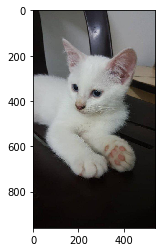

In [26]:
img = Image.open('petfinder-pawpularity-score/train/02df15ac385bf43109f3884c49612e62.jpg')
plt.imshow(img)

It can be seen that these images do not overlap at all. Which means that an accuracy of 80% is not enough. The accuracy should be at least 85%. Too few cat images have an accuracy of 85% so I decided not to put any more time and energy into this. I am going to look at another feature that could possibly be added to the PetFinder.my dataset. 

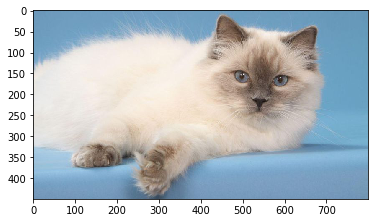

In [10]:
img = Image.open('0f8973327d_1464873469_De-ragdoll-is-de-enige-kat-die-wel-bij-je-op-schoot-blijft-zitten.jpeg')
plt.imshow(img)

Below can be seen a cat image from the PetFinder.my dataset predicting for 84% accuracy that it belongs to the siamese breed

In [192]:
%run /Users/kyrajongman/Documents/Fontys/cat-breeds-classifier-master/predict.py 'petfinder-pawpularity-score/train/0bf72e6419607359766952d774c3bd72.jpg'

Instructions for updating:
Use tf.gfile.GFile.
siamese (score = 0.84400)
birman (score = 0.10967)
ragdoll (score = 0.02962)
sphynx (score = 0.00657)
russian blue (score = 0.00231)
abyssinian (score = 0.00195)
persian (score = 0.00119)
bengal (score = 0.00113)
bombay (score = 0.00113)
british shorthair (score = 0.00109)
egyptian mau (score = 0.00091)
maine coon (score = 0.00042)


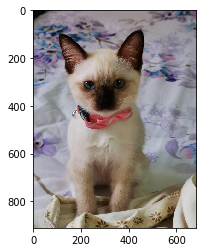

In [12]:
df_cat[df_cat['path'] == 'petfinder-pawpularity-score/train/0bf72e6419607359766952d774c3bd72.jpg'].index
img = Image.open(df_cat['path'][234]) 
plt.imshow(img)

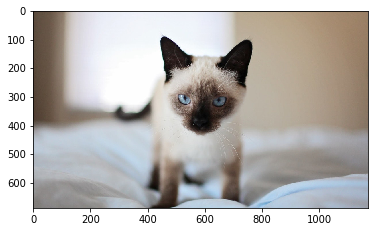

In [13]:
img = Image.open('siamkatze-katzenfutter-und-rasseportrait-w1170-h688.jpeg')
plt.imshow(img)

### 2. Feature colors in pictures

I used the code below to find out which 8 different colors an image consists of

In [69]:
def RGB2HEX(color):
    return "#{:02x}{:02x}{:02x}".format(int(color[0]), int(color[1]), int(color[2]))

def get_image(image_path):
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    return image

def get_colors(image, number_of_colors, show_chart):
    
    modified_image = cv2.resize(image, (600, 400), interpolation = cv2.INTER_AREA)
    modified_image = modified_image.reshape(modified_image.shape[0]*modified_image.shape[1], 3)
    
    clf = KMeans(n_clusters = number_of_colors)
    labels = clf.fit_predict(modified_image)
    
    counts = Counter(labels)
    # sort to ensure correct color percentage
    counts = dict(sorted(counts.items()))
    
    center_colors = clf.cluster_centers_
    # We get ordered colors by iterating through the keys
    ordered_colors = [center_colors[i] for i in counts.keys()]
    hex_colors = [RGB2HEX(ordered_colors[i]) for i in counts.keys()]
    rgb_colors = [ordered_colors[i] for i in counts.keys()]

    if (show_chart):
        plt.figure(figsize = (8, 6))
        plt.pie(counts.values(), labels = hex_colors, colors = hex_colors)
    
    return rgb_colors

Example of 8 colors in a particular image:

[array([32.81034913, 33.03470883, 36.11236133]),
 array([195.39362476, 189.84227537, 177.44392372]),
 array([ 42.81918809,  85.92885857, 119.8633507 ]),
 array([154.83528293, 148.03516313, 137.00274822]),
 array([69.93786119, 59.43958321, 62.50790964]),
 array([233.43605547, 230.16459712, 221.26801414]),
 array([28.28155127, 55.23222111, 73.35385627]),
 array([115.24003127, 109.32426375, 104.63455825])]

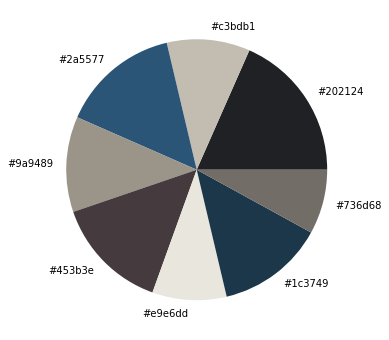

In [9]:
get_colors(get_image('petfinder-pawpularity-score/train/00a1ae8867e0bb89f061679e1cf29e80.jpg'), 8, True)

The image of the 8 different colors:

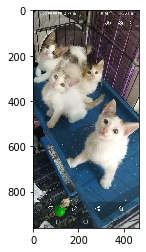

In [10]:
img = Image.open(df_cat['path'][9]) 
plt.imshow(img)

Another example of 8 colors in a particular image:

[array([156.3281188 , 156.66117305, 148.61186269]),
 array([67.91975732, 65.52513849, 55.47412292]),
 array([201.49235911, 202.78391661, 196.89200787]),
 array([127.73388821, 124.05271297, 110.27261564]),
 array([27.29228356, 27.84905897, 23.11091593]),
 array([221.63533516, 223.83562742, 226.60097106]),
 array([184.60798007, 185.26929255, 178.17917918]),
 array([102.18789722,  95.90435529,  79.12948883])]

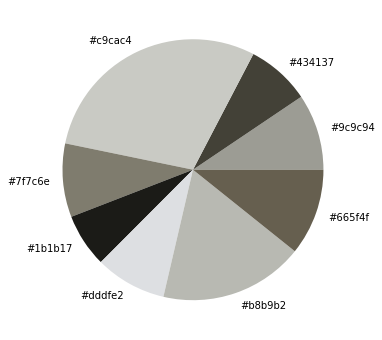

In [11]:
get_colors(get_image('petfinder-pawpularity-score/train/00e75d192cd4b26798933a817b04ccd9.jpg'), 8, True)

The image of the 8 different colors:

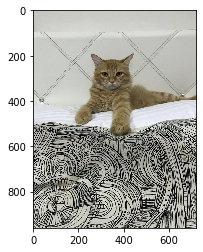

In [12]:
img = Image.open(df_cat['path'][15]) 
plt.imshow(img)

I have come to the conclusion that it is not convenient to include the 8 most common colors per image as a new feature in the prediction. 8 different colors is too specific so there will probably be no correlation between the pawpularity and the different colors. 

Then I started trying to see if I could get the color name of the most common color. I did this using the following code: 

In [185]:
hex_colors = []
for path in df_cat['path']:
    ints = [int(item) for item in get_colors(get_image(str(path)), 1, True)[0]]
    hex_colors.append(webcolors.rgb_to_hex(ints)) 

In [ ]:
with open("hex_colors.pkl", 'wb') as f:
        pickle.dump(hex_colors, f)

In [61]:
chrome_options = Options()
chrome_options.add_argument("--dns-prefetch-disable")
driver = webdriver.Chrome(executable_path="/Users/kyrajongman/Downloads/chromedriver", chrome_options = chrome_options)
driver.get('https://icolorpalette.com/')

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: DeprecationWarning: executable_path has been deprecated, please pass in a Service object
  This is separate from the ipykernel package so we can avoid doing imports until
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: DeprecationWarning: use options instead of chrome_options
  This is separate from the ipykernel package so we can avoid doing imports until


In [46]:
color_names_list = []
with open("hex_colors.pkl", 'rb') as f:
        hex_color = pickle.load(f)
        
for color in hex_color: 
    search_box = driver.find_element_by_xpath('//*[@id="wrapper-navbar"]/nav/div/div[2]/form/div/input')                                                   
    color = color.split('#')[1]
    search_box.send_keys(color)
    search_box.submit
    driver.find_element_by_xpath('//*[@id="wrapper-navbar"]/nav/div/div[2]/form/div/span/input').click()
    time.sleep(2)
    color_name = driver.find_element_by_xpath('//*[@id="content"]/div/div[1]/h1').text
    color_names_list.append(color_name)

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  # Remove the CWD from sys.path while we load stuff.
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  if sys.path[0] == '':


NoSuchElementException: Message: no such element: Unable to locate element: {"method":"xpath","selector":"//*[@id="content"]/div/div[1]/h1"}
  (Session info: chrome=96.0.4664.110)
Stacktrace:
0   chromedriver                        0x0000000106e83c99 __gxx_personality_v0 + 579209
1   chromedriver                        0x0000000106e0f5f3 __gxx_personality_v0 + 102371
2   chromedriver                        0x00000001069d5288 chromedriver + 172680
3   chromedriver                        0x0000000106a0a25c chromedriver + 389724
4   chromedriver                        0x0000000106a3c104 chromedriver + 594180
5   chromedriver                        0x0000000106a273cd chromedriver + 508877
6   chromedriver                        0x0000000106a39eab chromedriver + 585387
7   chromedriver                        0x0000000106a27693 chromedriver + 509587
8   chromedriver                        0x00000001069fdb7e chromedriver + 338814
9   chromedriver                        0x00000001069feea5 chromedriver + 343717
10  chromedriver                        0x0000000106e3f77f __gxx_personality_v0 + 299375
11  chromedriver                        0x0000000106e5668a __gxx_personality_v0 + 393338
12  chromedriver                        0x0000000106e5c8eb __gxx_personality_v0 + 418523
13  chromedriver                        0x0000000106e57a2a __gxx_personality_v0 + 398362
14  chromedriver                        0x0000000106e3434c __gxx_personality_v0 + 253244
15  chromedriver                        0x0000000106e73c48 __gxx_personality_v0 + 513592
16  chromedriver                        0x0000000106e73dd1 __gxx_personality_v0 + 513985
17  chromedriver                        0x0000000106e8b0c8 __gxx_personality_v0 + 608952
18  libsystem_pthread.dylib             0x00007ff81afa6514 _pthread_start + 125
19  libsystem_pthread.dylib             0x00007ff81afa202f thread_start + 15


In [62]:
for color in range(4967, len(hex_color)):
    search_box = driver.find_element_by_xpath('//*[@id="wrapper-navbar"]/nav/div/div[2]/form/div/input') 
    color = hex_color[color].split('#')[1]
    search_box.send_keys(color)
    search_box.submit
    driver.find_element_by_xpath('//*[@id="wrapper-navbar"]/nav/div/div[2]/form/div/span/input').click()
    time.sleep(2)
    color_name = driver.find_element_by_xpath('//*[@id="content"]/div/div[1]/h1').text
    color_names_list.append(color_name)

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  


In [120]:
color_name = []
for color in color_names_list:
    if '(' in color:
        color_name.append(color.split('(')[0])
    elif 'U' in color:
        color_name.append(color.split(' U')[0])
    elif 'Tpx' in color:
        color_name.append(color.split('Tpx ')[1].split(' Color')[0])
    elif 'Tpg' in color:
        color_name.append(color.split('Tpg ')[1].split(' Color')[0])
    elif 'Tcx' in color:
        color_name.append(color.split('Tcx ')[1].split(' Color')[0])
    elif 'C' in color:
        color_name.append(color.split(' C')[0])
    elif 'Color |' in color:
        color_name.append(color.split(' Color |')[0])
   
    else:
        color_name.append(color)

In [195]:
df_copy['color name'] = color_name
column_1 = df_copy["color name"].astype('category').cat.codes
column_2 = df_copy["Pawpularity"]
correlation = column_1.corr(column_2)
correlation

0.010086855783769907

Unfortunately, it also turned out that there are too many different types of color names so there was actually almost no correlation to be seen between pawpularity and the color name 

### 3. Feature brightness in pictures

To find out if there is a correlation between the brightness of a cat image and its popularity, I used the following code:

In [174]:
def brightness( im_file ):
    im = Image.open(im_file)
    stat = ImageStat.Stat(im)
    r,g,b = stat.mean
    return math.sqrt(0.299*(r**2) + 0.587*(g**2) + 0.114*(b**2))

An image is dark if it has an average pixel value of between 0 and 102 and is light if it has an average pixel value of 153 till 255

In [175]:
brightness_list = {'path': [], 'brightness': [], 'brightness class':[]}
for path in range(0, len(df_cat['path'])):
    if brightness(df_cat['path'][path]) < 51:
        brightness_class = "very dark"
    elif int(brightness(df_cat['path'][path])) < 102:
        brightness_class = "dark"
    elif int(brightness(df_cat['path'][path])) < 153:
        brightness_class = "neutral"  
    elif int(brightness(df_cat['path'][path])) < 204:
        brightness_class = "light"
    elif int(brightness(df_cat['path'][path])) <= 255:
        brightness_class = "very light"
    brightness_list['path'].append(df_cat['path'][path])
    brightness_list['brightness'].append(brightness(df_cat['path'][path]))
    brightness_list['brightness class'].append(brightness_class)

In [ ]:
with open("brightness_list.pkl", 'wb') as f:
    pickle.dump(brightness_list, f)
    

In [ ]:
with open("brightness_list.pkl", 'rb') as f:
       brightness = pickle.load(f)

In [214]:
for i in range(0, len(brightness_list['path'])):
    if i < 5:
        print('brightness value: ' + str(brightness_list['brightness'][i]) + '\n'
              'brightness class: ' + str(brightness_list['brightness class'][i]) + '\n')
    else: 
        pass

brightness value: 95.8280206020395
brightness class: dark

brightness value: 100.3238940021051
brightness class: dark

brightness value: 101.90527582962433
brightness class: dark

brightness value: 151.28805332083658
brightness class: neutral

brightness value: 162.47635605632414
brightness class: light



In [215]:
df_copy['brightness class'] = brightness_list['brightness class']
column_1 = df_copy['brightness class'].astype('category').cat.codes
column_2 = df_copy["Pawpularity"]
correlation = column_1.corr(column_2)
print('Correlation: ' + str(correlation))

Correlation: 0.028653060473921993


The correlation between the brightness class and the popularity is also not super, but still I am going to try to include them as new features for the prediction.

### 3. Feature brightness in all pictures of PetFinder.my dataset

In [6]:
def brightness( im_file ):
    im = Image.open(im_file)
    stat = ImageStat.Stat(im)
    r,g,b = stat.mean
    return math.sqrt(0.299*(r**2) + 0.587*(g**2) + 0.114*(b**2))

In [7]:
brightness_list_df = {'path': [], 'brightness': [], 'brightness class':[]}
for path in range(0, len(df['path'])):
    if brightness(df['path'][path]) < 51:
        brightness_class = "very dark"
    elif int(brightness(df['path'][path])) < 102:
        brightness_class = "dark"
    elif int(brightness(df['path'][path])) < 153:
        brightness_class = "neutral"  
    elif int(brightness(df['path'][path])) < 204:
        brightness_class = "light"
    elif int(brightness(df['path'][path])) <= 255:
        brightness_class = "very light"
    brightness_list_df['path'].append(df['path'][path])
    brightness_list_df['brightness'].append(brightness(df['path'][path]))
    brightness_list_df['brightness class'].append(brightness_class)

In [8]:
with open("brightness_list_df.pkl", 'wb') as f:
    pickle.dump(brightness_list_df, f)

In [9]:
with open("brightness_list_df.pkl", 'rb') as f:
       brightness_gehele_df = pickle.load(f)

In [14]:
df_copy = df.copy()
df_copy['brightness class'] = brightness_gehele_df['brightness class']
column_1 = df_copy['brightness class'].astype('category').cat.codes
column_2 = df_copy["Pawpularity"]
correlation = column_1.corr(column_2)
print('Correlation: ' + str(correlation))

Correlation: 0.022672718797581495
